In [1]:
import glob
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from fooof import FOOOF
from lagged_coherence import *
import mne
import json

In [6]:
data_dir='/home/common/mszul/explicit_implicit_beta/derivatives/processed/'
out_dir='/home/bonaiuto/lagged_hilbert_coherence/output/explicit-implicit/'
subj_groups=pd.read_csv(os.path.join(out_dir,'behav_df_cleaned_new.csv'))
#excluded=['sub-103','sub-112','sub-130','sub-131','sub-138','sub-140','sub-145']
excluded=['sub-115']

sub-101
sub-101 - explicit
sub-102
sub-102 - implicit
sub-103
sub-103 - explicit
sub-106
sub-106 - explicit
sub-107
sub-107 - implicit
sub-108
sub-108 - implicit
sub-109
sub-109 - implicit
sub-110
sub-110 - implicit
sub-111
sub-111 - implicit
sub-112
sub-112 - explicit
mot excluding 49
mot excluding 20
sub-113
sub-113 - explicit
mot excluding 8
mot excluding 41
mot excluding 7
mot excluding 24
mot excluding 25
sub-114
sub-114 - explicit
mot excluding 25
sub-117
sub-117 - explicit
mot excluding 26
sub-118
sub-118 - explicit
sub-119
sub-119 - implicit
sub-120
sub-120 - explicit
sub-122
sub-122 - implicit
sub-123
sub-123 - implicit
mot excluding 13
mot excluding 16
mot excluding 0
mot excluding 51
mot excluding 24
sub-124
sub-124 - explicit
mot excluding 0
sub-126
sub-126 - implicit
sub-127
sub-127 - implicit


/tmp/ipykernel_3100/1497574401.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


sub-129
sub-129 - implicit
sub-130
sub-130 - explicit
sub-131
sub-131 - implicit
sub-132
sub-132 - implicit
sub-133
sub-133 - explicit
sub-134
sub-134 - explicit
mot excluding 13
mot excluding 48
mot excluding 38
sub-135
sub-135 - implicit
sub-136
sub-136 - explicit
mot excluding 50
sub-138
sub-138 - explicit
sub-139
sub-139 - implicit
sub-140
sub-140 - explicit
sub-141
sub-141 - implicit
sub-142
sub-142 - implicit
sub-143
sub-143 - explicit
mot excluding 16
sub-144
sub-144 - implicit
sub-145
sub-145 - explicit


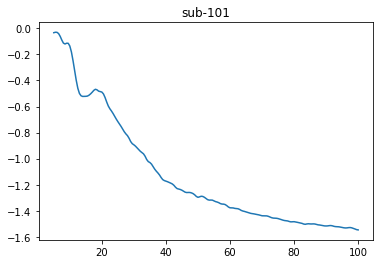

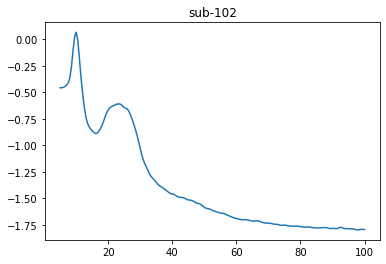

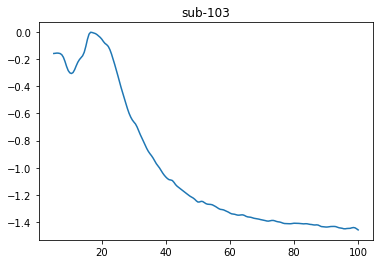

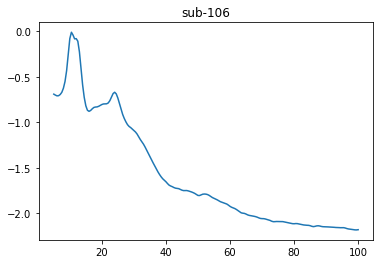

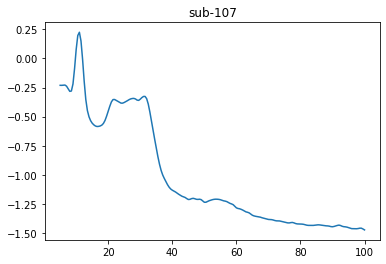

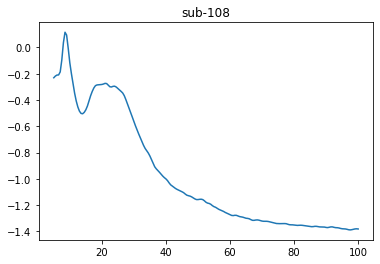

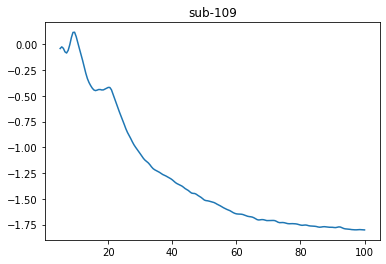

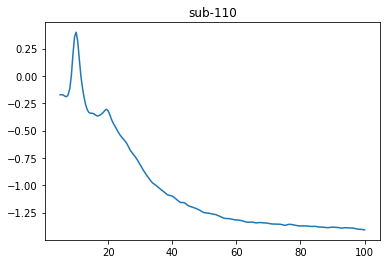

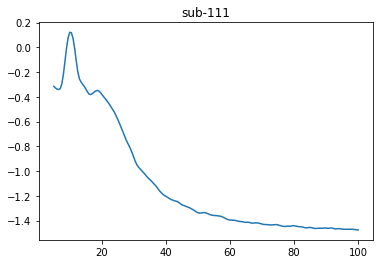

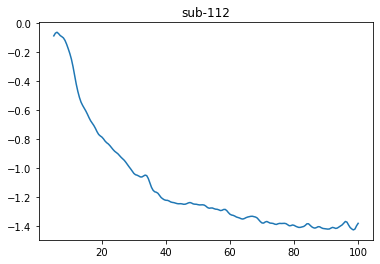

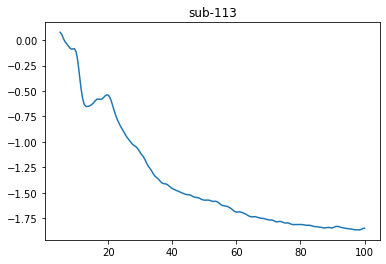

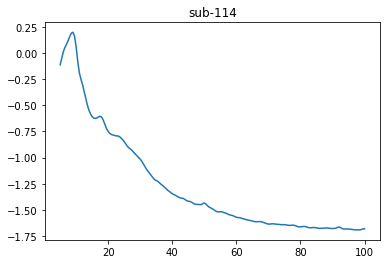

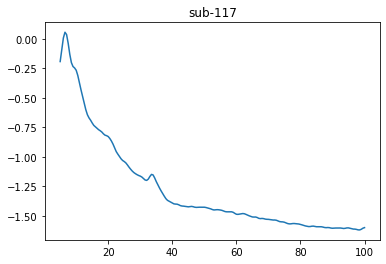

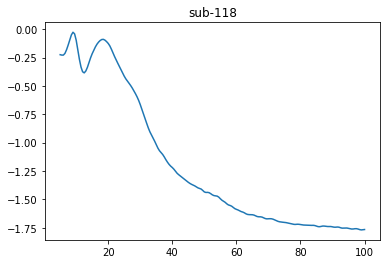

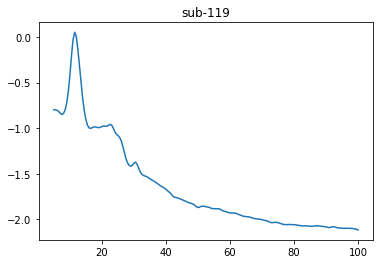

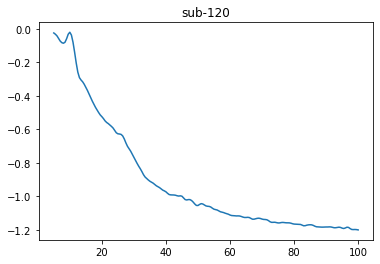

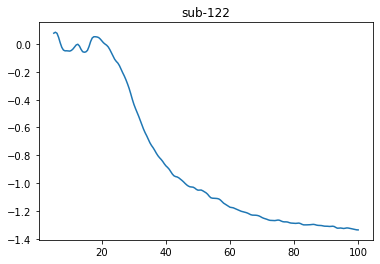

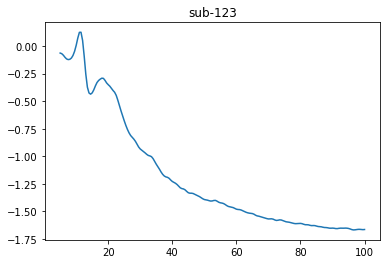

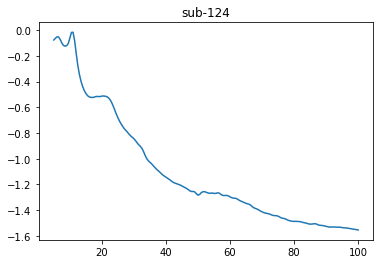

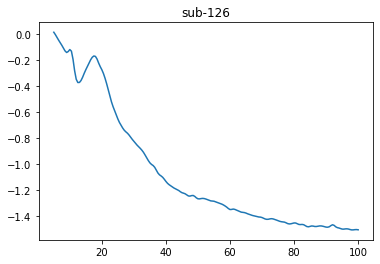

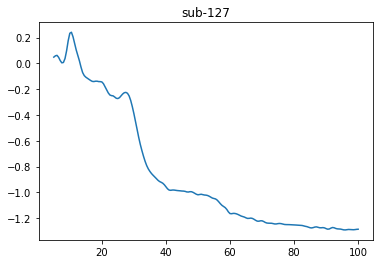

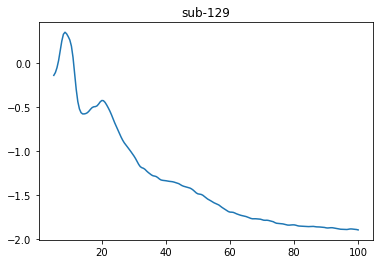

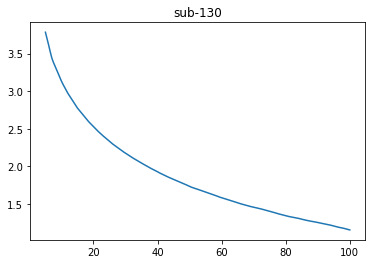

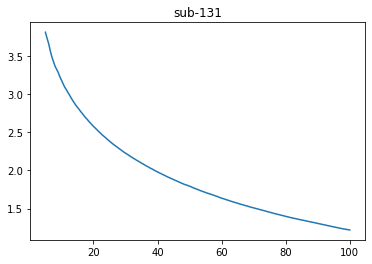

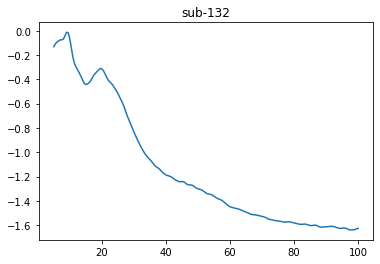

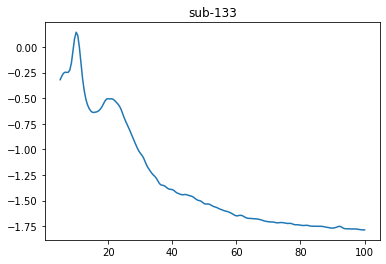

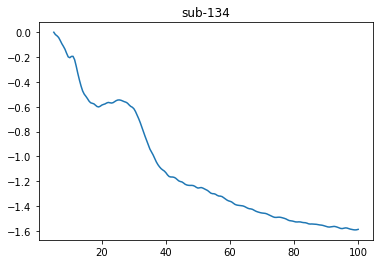

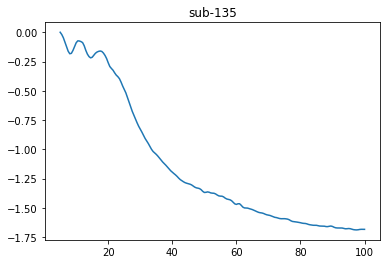

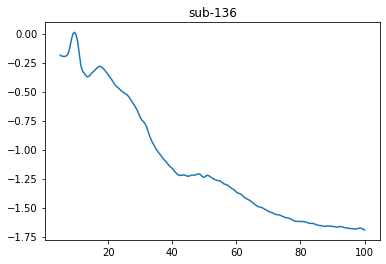

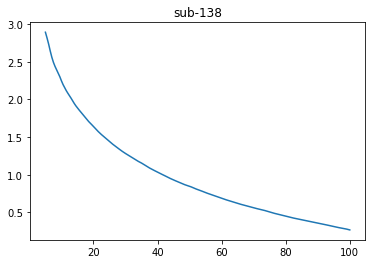

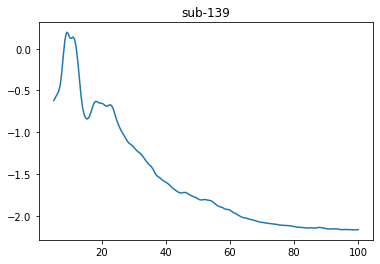

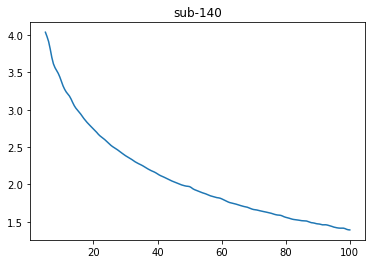

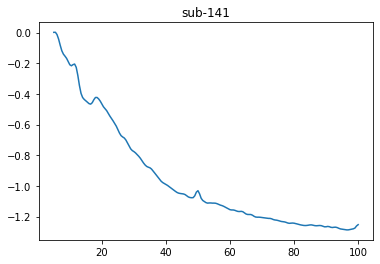

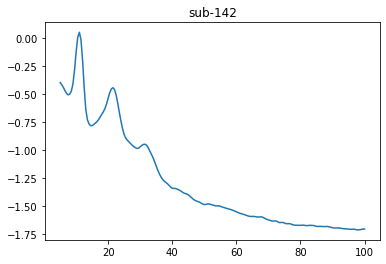

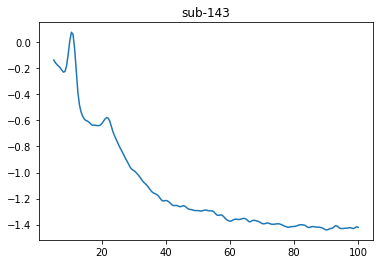

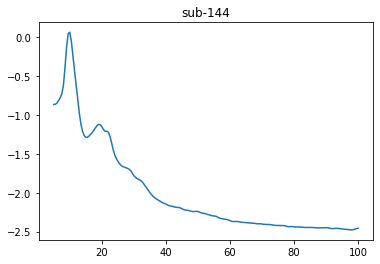

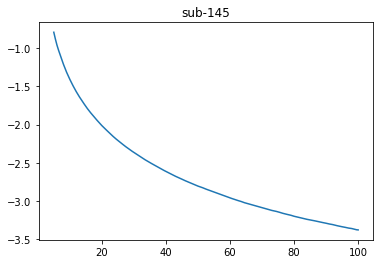

In [7]:
sub_paths=sorted(glob.glob(os.path.join(out_dir,'sub-*')))
all_vis_lc={
    'implicit': [],
    'explicit': []
}
all_mot_lc={
    'implicit': [],
    'explicit': []
}
all_vis_psd={
    'implicit': [],
    'explicit': []
}
all_mot_psd={
    'implicit': [],
    'explicit': []
}
for sub_idx, sub_path in enumerate(sub_paths):
    sub=os.path.split(sub_path)[-1]
    if not sub in excluded:
        group = subj_groups[subj_groups['subject'] == sub]['group'].values[0].lower()
        sub_out_path=os.path.join(out_dir,sub)

        print('{} - {}'.format(sub,group))

        vis_epo_paths=sorted(glob.glob(os.path.join(sub_path,'{}-*-visual.npz'.format(sub))))
        if len(vis_epo_paths)==8:
            sub_psd=[]
            sub_lc=[]
            max_lc=None
            max_psd=None
            for epo_path in vis_epo_paths:
                block_num=os.path.split(epo_path)[-1].split('-')[2]
                res=dict(np.load(epo_path))
                freqs=res['freqs']
                lags=res['lags']
                # Average PSD over channels
                mean_psd=np.mean(res['psd'],axis=0)
                # Average LC over trials then channels
                included_trials=[]
                for t in range(res['lc'].shape[1]):
                    trial_mean=np.mean(res['lc'][:,t,:,:],axis=0)
                    if np.sum(trial_mean[:,0])>0.01:
                        included_trials.append(t)
                    else:
                        print('vis excluding {}'.format(t))
                included_trials=np.array(included_trials)
                mean_lc=np.mean(np.mean(res['lc'][:,included_trials,:,:],axis=1),axis=0)
                if max_lc is None:
                    max_lc=np.max(mean_lc)
                mean_lc=mean_lc/max_lc
                if max_psd is None:
                    max_psd=np.max(mean_psd)
                mean_psd=mean_psd/max_psd
                sub_psd.append(mean_psd)
                sub_lc.append(mean_lc)
            sub_vis_psd=np.array(sub_psd)
            sub_vis_lc=np.array(sub_lc)
            all_vis_psd[group].append(sub_vis_psd)
            all_vis_lc[group].append(gaussian_filter1d(sub_vis_lc,1.5,axis=1))
            plt.figure()
            plt.plot(freqs,np.log10(np.mean(sub_vis_psd,axis=0)))
            plt.title(sub)

            mot_epo_paths=sorted(glob.glob(os.path.join(sub_path,'{}-*-motor.npz'.format(sub))))
            sub_psd=[]
            sub_lc=[]
            max_lc=None
            for epo_path in mot_epo_paths:
                block_num=os.path.split(epo_path)[-1].split('-')[2]
                res=dict(np.load(epo_path))
                freqs=res['freqs']
                lags=res['lags']
                mean_psd=np.mean(res['psd'],axis=0)
                included_trials=[]
                for t in range(res['lc'].shape[1]):
                    trial_mean=np.mean(res['lc'][:,t,:,:],axis=0)
                    if np.sum(trial_mean[:,0])>0.01:
                        included_trials.append(t)
                    else:
                        print('mot excluding {}'.format(t))
                included_trials=np.array(included_trials)
                mean_lc=np.mean(np.mean(res['lc'][:,included_trials,:,:],axis=1),axis=0)
                if max_lc is None:
                    max_lc=np.max(mean_lc)
                mean_lc=mean_lc/max_lc
                if max_psd is None:
                    max_psd=np.max(mean_psd)
                mean_psd=mean_psd/max_psd
                sub_psd.append(mean_psd)
                sub_lc.append(mean_lc)
            sub_mot_psd=np.array(sub_psd)
            sub_mot_lc=np.array(sub_lc)
            all_mot_psd[group].append(sub_mot_psd)
            all_mot_lc[group].append(gaussian_filter1d(sub_mot_lc,1.5,axis=1))

for group in ['implicit','explicit']:
    all_vis_lc[group]=np.array(all_vis_lc[group])
    all_mot_lc[group]=np.array(all_mot_lc[group])
    all_vis_psd[group]=np.array(all_vis_psd[group])
    all_mot_psd[group]=np.array(all_mot_psd[group])

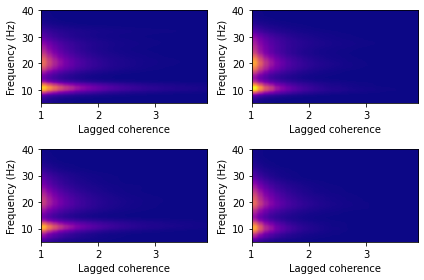

In [8]:
plt.figure()

mean_vis_implicit=np.mean(np.mean(all_vis_lc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_implicit=np.mean(np.mean(all_mot_lc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_vis_explicit=np.mean(np.mean(all_vis_lc['explicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_explicit=np.mean(np.mean(all_mot_lc['explicit'][:,1:-1,:,:],axis=1),axis=0)

vmin=0
vmax=np.max(np.vstack([mean_vis_implicit,mean_mot_implicit,mean_vis_explicit,mean_mot_explicit]))

plt.subplot(2,2,1)
i1=plt.imshow(mean_vis_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Lagged coherence')
plt.ylim([5,40])

plt.subplot(2,2,2)
i1=plt.imshow(mean_mot_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Lagged coherence')
plt.ylim([5,40])

plt.subplot(2,2,3)
i1=plt.imshow(mean_vis_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Lagged coherence')
plt.ylim([5,40])

plt.subplot(2,2,4)
i1=plt.imshow(mean_mot_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Lagged coherence')
plt.ylim([5,40])
plt.tight_layout()

In [56]:
mean_vis_implicit[:].shape

(191, 30)

In [50]:
all_vis_lc['implicit'][:,1:-1,:,:].shape

(20, 6, 191, 30)

alpha
mot int diff: 3 p=0.003
mot int diff: 4 p=0.001
mot int diff: 5 p=0.004
mot int diff: 7 p=0.009
mot area diff: 2 p=0.002
mot area diff: 3 p=0.007
mot area diff: 4 p=0.001
beta
vis int diff: 2 p=0.031
mot int diff: 2 p=0.037
vis int diff: 3 p=0.005
mot int diff: 3 p=0.003
mot int diff: 4 p=0.017
mot int diff: 5 p=0.043
mot int diff: 7 p=0.031
vis area diff: 3 p=0.012
mot area diff: 3 p=0.007
mot area diff: 4 p=0.007
vis area diff: 5 p=0.032
mot area diff: 5 p=0.046


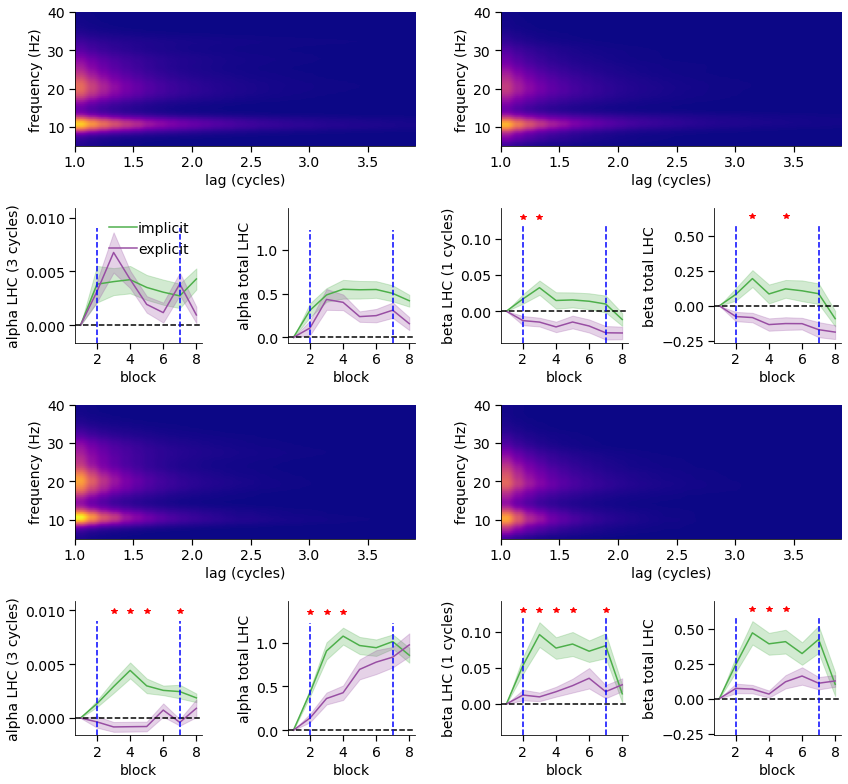

In [10]:
from functools import partial
from mne.stats import permutation_cluster_test, ttest_ind_no_p, permutation_t_test

def bootstrap_permutation_test(imp, exp, num_permutations):
    # Compute the observed difference in means
    observed_diff = np.mean(imp) - np.mean(exp)

    # Combine all measurements into a single dataset
    combined = np.concatenate((imp, exp))

    # Perform permutations
    count = 0
    for _ in range(num_permutations):
        # Bootstrap sampling with replacement from the combined dataset
        bootstrap_sample = np.random.choice(combined, num_permutations, replace=True)

        # Split it into two new groups
        new_imp = bootstrap_sample[:len(imp)]
        new_exp = bootstrap_sample[len(imp):]

        # Compute the difference in means for the permuted groups
        permuted_diff = np.mean(new_imp) - np.mean(new_exp)

        # Count if the permuted difference is at least as extreme as the observed difference
        if abs(permuted_diff) >= abs(observed_diff):
            count += 1

    # Compute the p-value
    p_value = count / num_permutations

    return p_value


sessions=np.arange(1,9)
    
freq_ranges={
    'alpha': [7,13],
    'beta': [15,30],
}
freq_lags={
    'alpha': 3,
    'beta': 1,
}

mean_vis_implicit=np.mean(np.mean(all_vis_lc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_implicit=np.mean(np.mean(all_mot_lc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_vis_explicit=np.mean(np.mean(all_vis_lc['explicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_explicit=np.mean(np.mean(all_mot_lc['explicit'][:,1:-1,:,:],axis=1),axis=0)


vis_diffs=[]
mot_diffs=[]
for g_idx,group in enumerate(['implicit','explicit']):
    
    first_vis_lc=all_vis_lc[group][:,0,:,:]
    vis_diff=(all_vis_lc[group]-first_vis_lc[:,None,:,:])
    first_mot_lc=all_mot_lc[group][:,0,:,:]
    mot_diff=(all_mot_lc[group]-first_mot_lc[:,None,:,:])

    vis_diffs.append(vis_diff)
    mot_diffs.append(mot_diff)

n_perms=1000

plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

colors={
    'implicit': np.array([77,175,74])/255,
    'explicit': np.array([152,78,163])/255
}

fig=plt.figure(figsize=(12,16))
gs = fig.add_gridspec(6,4)

vmin=0
vmax=np.max(np.vstack([mean_vis_implicit,mean_mot_implicit,mean_vis_explicit,mean_mot_explicit]))

ax = fig.add_subplot(gs[0,0:2])
i1=ax.imshow(mean_vis_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('lag (cycles)')
ax.set_ylim([5,40])

ax = fig.add_subplot(gs[2,0:2])
i1=plt.imshow(mean_mot_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('lag (cycles)')
ax.set_ylim([5,40])

ax = fig.add_subplot(gs[0,2:4])
i1=ax.imshow(mean_vis_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('lag (cycles)')
ax.set_ylim([5,40])

ax = fig.add_subplot(gs[2,2:4])
i1=plt.imshow(mean_mot_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('lag (cycles)')
ax.set_ylim([5,40])

for b_idx,band in enumerate(['alpha','beta']):
    print(band)
    freq_range=freq_ranges[band]
    freq_idx=np.where((freqs>=freq_range[0]) & (freqs<=freq_range[1]))[0]
    lag_idx=np.argmin(np.abs(lags-freq_lags[band]))
    
    
    # Intercept
    ax1 = fig.add_subplot(gs[1,b_idx*2])
    ax2 = fig.add_subplot(gs[3,b_idx*2])
    
    band_vis_int_diffs=[]
    band_mot_int_diffs=[]
    for g_idx,group in enumerate(['implicit','explicit']):
        band_vis_int_diff=np.mean(vis_diffs[g_idx][:,:,freq_idx,lag_idx],axis=2)
        m_band_vis_int_diff=np.mean(band_vis_int_diff,axis=0)
        se_band_vis_int_diff=np.std(band_vis_int_diff,axis=0)/np.sqrt(band_vis_int_diff.shape[0])
        ax1.fill_between(sessions,
                         m_band_vis_int_diff-.5*se_band_vis_int_diff,
                         m_band_vis_int_diff+.5*se_band_vis_int_diff,
                         alpha=0.25, color=colors[group])
        ax1.plot(sessions,m_band_vis_int_diff,label=group, color=colors[group])
        band_vis_int_diffs.append(band_vis_int_diff)
        
        band_mot_int_diff=np.mean(mot_diffs[g_idx][:,:,freq_idx,lag_idx],axis=2)
        m_band_mot_int_diff=np.mean(band_mot_int_diff,axis=0)
        se_band_mot_int_diff=np.std(band_mot_int_diff,axis=0)/np.sqrt(band_mot_int_diff.shape[0])
        plt.fill_between(sessions,
                         m_band_mot_int_diff-.5*se_band_mot_int_diff,
                         m_band_mot_int_diff+.5*se_band_mot_int_diff,
                         alpha=0.25, color=colors[group])
        plt.plot(sessions,m_band_mot_int_diff,label=group, color=colors[group])
        band_mot_int_diffs.append(band_mot_int_diff)
    
    ax1.set_ylabel('{} LHC ({} cycles)'.format(band, freq_lags[band]))
    ax2.set_ylabel('{} LHC ({} cycles)'.format(band, freq_lags[band]))
    ax1.set_xlabel('block')
    ax2.set_xlabel('block')
    
    ax1.set_xticks([2,4,6,8])
    ax2.set_xticks([2,4,6,8])
    
    yl1=ax1.get_ylim()
    yl2=ax2.get_ylim()
    yl=[np.min([yl1[0],yl2[0]]), np.max([yl1[1],yl2[1]])]
        
    ax1.set_ylim(yl)
    ax2.set_ylim(yl)
        
    xl=ax1.get_xlim()
    ax1.plot(xl,[0,0],'k--')
    ax2.plot(xl,[0,0],'k--')
    ax1.set_xlim(xl)
    ax2.set_xlim(xl)
    
    ax1.plot([2,2],yl,'b--')
    ax1.plot([7,7],yl,'b--')
    ax2.plot([2,2],yl,'b--')
    ax2.plot([7,7],yl,'b--')
    
    pos_range=yl[1]
    for i in range(len(sessions)):
        p=bootstrap_permutation_test(band_vis_int_diffs[0][:,i], band_vis_int_diffs[1][:,i], n_perms)
        if p<0.05:
            print(f'vis int diff: {sessions[i]} p={p}')
            ax1.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
            
        p=bootstrap_permutation_test(band_mot_int_diffs[0][:,i], band_mot_int_diffs[1][:,i], n_perms)
        if p<0.05:
            print(f'mot int diff: {sessions[i]} p={p}')
            ax2.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
    ax1.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    ax2.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    
    if b_idx==0:
        ax1.legend()
        
        
    ax1 = fig.add_subplot(gs[1,b_idx*2+1])
    ax2 = fig.add_subplot(gs[3,b_idx*2+1])
    
    band_vis_area_diffs=[]
    band_mot_area_diffs=[]
    for g_idx,group in enumerate(['implicit','explicit']):
        band_vis_area_diff=np.mean(np.sum(vis_diffs[g_idx][:,:,freq_idx,:],axis=3),axis=2)
        m_band_vis_area_diff=np.mean(band_vis_area_diff,axis=0)
        se_band_vis_area_diff=np.std(band_vis_area_diff,axis=0)/np.sqrt(band_vis_area_diff.shape[0])
        ax1.fill_between(sessions,
                         m_band_vis_area_diff-.5*se_band_vis_area_diff,
                         m_band_vis_area_diff+.5*se_band_vis_area_diff,
                         alpha=0.25, color=colors[group])
        ax1.plot(sessions,m_band_vis_area_diff,label=group, color=colors[group])
        band_vis_area_diffs.append(band_vis_area_diff)
        
        band_mot_area_diff=np.mean(np.sum(mot_diffs[g_idx][:,:,freq_idx,:],axis=3),axis=2)
        m_band_mot_area_diff=np.mean(band_mot_area_diff,axis=0)
        se_band_mot_area_diff=np.std(band_mot_area_diff,axis=0)/np.sqrt(band_mot_area_diff.shape[0])
        plt.fill_between(sessions,
                         m_band_mot_area_diff-.5*se_band_mot_area_diff,
                         m_band_mot_area_diff+.5*se_band_mot_area_diff,
                         alpha=0.25, color=colors[group])
        plt.plot(sessions,m_band_mot_area_diff,label=group, color=colors[group])
        band_mot_area_diffs.append(band_mot_area_diff)
    
    ax1.set_ylabel('{} total LHC'.format(band))
    ax2.set_ylabel('{} total LHC'.format(band))
    ax1.set_xlabel('block')
    ax2.set_xlabel('block')
    
    ax1.set_xticks([2,4,6,8])
    ax2.set_xticks([2,4,6,8])
    
    yl1=ax1.get_ylim()
    yl2=ax2.get_ylim()
    yl=[np.min([yl1[0],yl2[0]]), np.max([yl1[1],yl2[1]])]
        
    ax1.set_ylim(yl)
    ax2.set_ylim(yl)
        
    xl=ax1.get_xlim()
    ax1.plot(xl,[0,0],'k--')
    ax2.plot(xl,[0,0],'k--')
    ax1.set_xlim(xl)
    ax2.set_xlim(xl)
    
    ax1.plot([2,2],yl,'b--')
    ax1.plot([7,7],yl,'b--')
    ax2.plot([2,2],yl,'b--')
    ax2.plot([7,7],yl,'b--')
    
    pos_range=yl[1]
    for i in range(len(sessions)):
        p=bootstrap_permutation_test(band_vis_area_diffs[0][:,i], band_vis_area_diffs[1][:,i], n_perms)
        if p<0.05:
            print(f'vis area diff: {sessions[i]} p={p}')
            ax1.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
            
        p=bootstrap_permutation_test(band_mot_area_diffs[0][:,i], band_mot_area_diffs[1][:,i], n_perms)
        if p<0.05:
            print(f'mot area diff: {sessions[i]} p={p}')
            ax2.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
    ax1.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    ax2.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    
plt.tight_layout()

fig.savefig('../output/figures/figure_3.svg')
fig.savefig('../output/figures/figure_3.png')

/tmp/ipykernel_33176/3153833818.py:1: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb=plt.colorbar(i1, label='lagged Hilbert coherence')


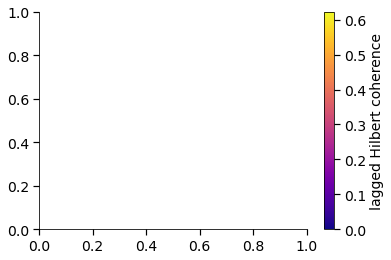

In [97]:
cb=plt.colorbar(i1, label='lagged Hilbert coherence')
plt.savefig('../output/figures/figure_3_cb.svg')
plt.savefig('../output/figures/figure_3_cb.png')